# Setup and Environment

In [ ]:
!pip install -q torch transformers tqdm matplotlib

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: Tesla T4
Memory: 15.8 GB


# Load Preprocessed Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Update this path to where you saved your tokenized data
DATA_PATH = '/content/drive/MyDrive/NEU/CSYE7374/processed/full_tokenized_dataset.pt'

print("Loading tokenized data...")
tokenized_data = torch.load(DATA_PATH)

print(f"Data loaded successfully!")
print(f"Sources: {list(tokenized_data.keys())}")
for source, blocks in tokenized_data.items():
    print(f"  {source}: {len(blocks)} blocks")

total_blocks = sum(len(blocks) for blocks in tokenized_data.values())
print(f"Total blocks: {total_blocks}")

Mounted at /content/drive
Loading tokenized data...
Data loaded successfully!
Sources: ['wikitext', 'openwebtext', 'ag_news']
  wikitext: 189 blocks
  openwebtext: 312366 blocks
  ag_news: 0 blocks
Total blocks: 312555


In [ ]:
import os
SAVE_DIR = '/content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f"All files will be saved to: {SAVE_DIR}")

All files will be saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs


# Create Dataset and **DataLoader**

In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

class TextDataset(Dataset):
    def __init__(self, tokenized_data_dict, seq_len=128):
        self.seq_len = seq_len
        self.data = []
        for source, blocks in tokenized_data_dict.items():
            if len(blocks) > 0:  # Skip empty sources like ag_news
                self.data.extend(blocks)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        block = self.data[idx][:self.seq_len]
        input_ids = torch.tensor(block, dtype=torch.long)
        return {
            'input_ids': input_ids,
            'labels': input_ids.clone()
        }

# Create full dataset
SEQ_LEN = 128
full_dataset = TextDataset(tokenized_data, seq_len=SEQ_LEN)

# Split into train (90%) and validation (10%)
train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create dataloaders
BATCH_SIZE = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset Statistics:")
print(f"  Total samples: {len(full_dataset):,}")
print(f"  Training samples: {len(train_dataset):,} (90%)")
print(f"  Validation samples: {len(val_dataset):,} (10%)")
print(f"  Sequence length: {SEQ_LEN}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"\nDataLoader Info:")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches: {len(val_loader):,}")
print(f"  Estimated steps per epoch: {len(train_loader):,}")

Dataset Statistics:
  Total samples: 312,555
  Training samples: 281,299 (90%)
  Validation samples: 31,256 (10%)
  Sequence length: 128
  Batch size: 32

DataLoader Info:
  Train batches: 8,791
  Val batches: 977
  Estimated steps per epoch: 8,791


# Model Architecture

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B, T, C = x.shape

        q = self.q_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attn = attn.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.dropout(attn)

        out = (attn @ v).transpose(1, 2).contiguous().view(B, T, C)
        return self.out_proj(out)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x, mask=None):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.ff(self.ln2(x))
        return x

class MiniGPT(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, max_seq_len, dropout=0.1):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, embed_dim)
        self.pos_emb = nn.Embedding(max_seq_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

        ff_dim = embed_dim * 4
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)

        self.max_seq_len = max_seq_len
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, input_ids):
        B, T = input_ids.shape

        tok_emb = self.token_emb(input_ids)
        pos = torch.arange(0, T, device=input_ids.device).unsqueeze(0)
        pos_emb = self.pos_emb(pos)
        x = self.dropout(tok_emb + pos_emb)

        mask = torch.tril(torch.ones(T, T, device=input_ids.device)).unsqueeze(0).unsqueeze(0)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)
        return logits

# Model configuration
VOCAB_SIZE = 50257
EMBED_DIM = 128
NUM_HEADS = 4
NUM_LAYERS = 2
MAX_SEQ_LEN = SEQ_LEN
DROPOUT = 0.1

model = MiniGPT(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Configuration:")
print(f"  Vocab size: {VOCAB_SIZE}")
print(f"  Embedding dim: {EMBED_DIM}")
print(f"  Attention heads: {NUM_HEADS}")
print(f"  Transformer layers: {NUM_LAYERS}")
print(f"  Max sequence length: {MAX_SEQ_LEN}")
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Configuration:
  Vocab size: 50257
  Embedding dim: 128
  Attention heads: 4
  Transformer layers: 2
  Max sequence length: 128

Total parameters: 13,278,976
Trainable parameters: 13,278,976


# Training Functions

In [ ]:
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = 0

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids)

        # Shift logits and labels for next-token prediction
        # logits: predict token at position i+1, labels: actual token at position i+1
        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        avg_loss = total_loss / num_batches
        perplexity = math.exp(avg_loss)
        progress_bar.set_postfix({'loss': f'{avg_loss:.4f}', 'ppl': f'{perplexity:.2f}'})

    avg_loss = total_loss / num_batches
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

def validate_epoch(model, val_loader, device):
    """
    Evaluate model on validation set
    Returns average validation loss
    """
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids)

            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1)
            )

            total_loss += loss.item()
            num_batches += 1

    avg_loss = total_loss / num_batches
    return avg_loss


def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, path, history=None):
    """
    Save model checkpoint with training history
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_perplexity': math.exp(train_loss),
        'val_perplexity': math.exp(val_loss),
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved to: {path}")

# Training Configuration

In [ ]:
LEARNING_RATE = 5e-4
NUM_EPOCHS = 2

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# History tracking for BOTH train and validation
train_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("="*60)
print("TRAINING CONFIGURATION")
print("="*60)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Optimizer: AdamW")
print(f"Gradient clipping: 1.0")
print(f"Batch size: {BATCH_SIZE}")
print(f"\nDataset Info:")
print(f"  Training batches per epoch: {len(train_loader):,}")
print(f"  Validation batches per epoch: {len(val_loader):,}")
print(f"  Total training steps: {NUM_EPOCHS * len(train_loader):,}")
print(f"\nSave directory: {SAVE_DIR}")
print("="*60)

# Experiment 1: Baseline Training

In [10]:
print("="*60)
print("EXPERIMENT 1: BASELINE TRAINING")
print("="*60)
print("Config: embed_dim=128, heads=4, layers=2, lr=5e-4, batch_size=32")
print("="*60)

LOG_INTERVAL = 500

exp1_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

step_history = {
    'step': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("\nStarting training...\n")

global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    model.train()
    epoch_train_loss = 0
    num_train_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        num_train_batches += 1
        global_step += 1

        current_avg_loss = epoch_train_loss / num_train_batches
        current_ppl = math.exp(current_avg_loss)
        progress_bar.set_postfix({
            'loss': f'{current_avg_loss:.4f}',
            'ppl': f'{current_ppl:.2f}'
        })

        if global_step % LOG_INTERVAL == 0:
            model.eval()
            val_loss_sample = 0
            with torch.no_grad():
                for i, val_batch in enumerate(val_loader):
                    if i >= 10:
                        break
                    val_input = val_batch['input_ids'].to(device)
                    val_labels = val_batch['labels'].to(device)
                    val_logits = model(val_input)
                    val_shift_logits = val_logits[:, :-1, :].contiguous()
                    val_shift_labels = val_labels[:, 1:].contiguous()
                    val_loss = F.cross_entropy(
                        val_shift_logits.view(-1, val_shift_logits.size(-1)),
                        val_shift_labels.view(-1)
                    )
                    val_loss_sample += val_loss.item()
            val_loss_sample /= 10

            step_history['step'].append(global_step)
            step_history['train_loss'].append(batch_loss)
            step_history['train_perplexity'].append(math.exp(batch_loss))
            step_history['val_loss'].append(val_loss_sample)
            step_history['val_perplexity'].append(math.exp(val_loss_sample))

            model.train()

    avg_train_loss = epoch_train_loss / num_train_batches
    train_perplexity = math.exp(avg_train_loss)

    print(f"\nRunning validation...")
    avg_val_loss = validate_epoch(model, val_loader, device)
    val_perplexity = math.exp(avg_val_loss)

    exp1_history['epoch'].append(epoch)
    exp1_history['train_loss'].append(avg_train_loss)
    exp1_history['train_perplexity'].append(train_perplexity)
    exp1_history['val_loss'].append(avg_val_loss)
    exp1_history['val_perplexity'].append(val_perplexity)

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training   -> Loss: {avg_train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"Validation -> Loss: {avg_val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    print(f"{'='*60}")

    checkpoint_path = f'{SAVE_DIR}/exp1_baseline_epoch{epoch}.pt'
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_perplexity': train_perplexity,
        'val_perplexity': val_perplexity,
        'epoch_history': exp1_history,
        'step_history': step_history
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("EXPERIMENT 1 COMPLETE!")
print("="*60)
print(f"Final Training Loss: {exp1_history['train_loss'][-1]:.4f}")
print(f"Final Training Perplexity: {exp1_history['train_perplexity'][-1]:.2f}")
print(f"Final Validation Loss: {exp1_history['val_loss'][-1]:.4f}")
print(f"Final Validation Perplexity: {exp1_history['val_perplexity'][-1]:.2f}")
print(f"Total steps logged: {len(step_history['step'])}")
print("="*60)

EXPERIMENT 1: BASELINE TRAINING
Config: embed_dim=128, heads=4, layers=2, lr=5e-4, batch_size=32

Starting training...


EPOCH 1/2


Training Epoch 1: 100%|██████████| 8791/8791 [14:59<00:00,  9.77it/s, loss=5.7457, ppl=312.83]


Running validation...



EPOCH 1 SUMMARY
Training   -> Loss: 5.7457 | Perplexity: 312.83
Validation -> Loss: 5.2611 | Perplexity: 192.69
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp1_baseline_epoch1.pt

EPOCH 2/2


Training Epoch 2: 100%|██████████| 8791/8791 [15:03<00:00,  9.73it/s, loss=5.2449, ppl=189.59]


Running validation...



EPOCH 2 SUMMARY
Training   -> Loss: 5.2449 | Perplexity: 189.59
Validation -> Loss: 5.0790 | Perplexity: 160.61
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp1_baseline_epoch2.pt

EXPERIMENT 1 COMPLETE!
Final Training Loss: 5.2449
Final Training Perplexity: 189.59
Final Validation Loss: 5.0790
Final Validation Perplexity: 160.61
Total steps logged: 35


EXPERIMENT 1: TRAINING VISUALIZATION


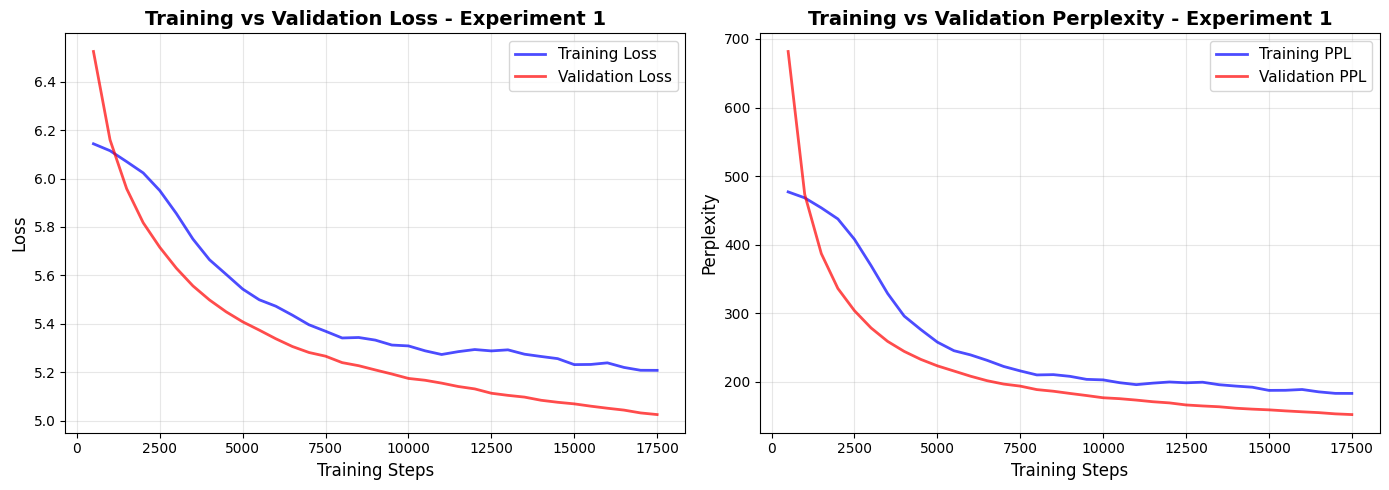


✓ Plot saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp1_training_curves.png


In [11]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("="*60)
print("EXPERIMENT 1: TRAINING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = step_history['step']
smooth_train_loss = uniform_filter1d(step_history['train_loss'], size=10)
smooth_train_ppl = uniform_filter1d(step_history['train_perplexity'], size=10)

axes[0].plot(steps, smooth_train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
axes[0].plot(steps, step_history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss - Experiment 1', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, smooth_train_ppl, 'b-', label='Training PPL', linewidth=2, alpha=0.7)
axes[1].plot(steps, step_history['val_perplexity'], 'r-', label='Validation PPL', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Training vs Validation Perplexity - Experiment 1', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/exp1_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

# Experiment 2: Learning Rate = 1e-**3**

In [ ]:
print("="*60)
print("EXPERIMENT 2: LEARNING RATE = 1e-3")
print("="*60)
print("Config: embed_dim=128, heads=4, layers=2, lr=1e-3, batch_size=32")
print("="*60)

model_exp2 = MiniGPT(
    vocab_size=VOCAB_SIZE,
    embed_dim=128,
    num_heads=4,
    num_layers=2,
    max_seq_len=SEQ_LEN,
    dropout=0.1
).to(device)

optimizer_exp2 = torch.optim.AdamW(model_exp2.parameters(), lr=1e-3)

LOG_INTERVAL = 500

exp2_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

exp2_step_history = {
    'step': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("\nStarting training...\n")

global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    model_exp2.train()
    epoch_train_loss = 0
    num_train_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer_exp2.zero_grad()
        logits = model_exp2(input_ids)

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_exp2.parameters(), max_norm=1.0)
        optimizer_exp2.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        num_train_batches += 1
        global_step += 1

        current_avg_loss = epoch_train_loss / num_train_batches
        current_ppl = math.exp(current_avg_loss)
        progress_bar.set_postfix({
            'loss': f'{current_avg_loss:.4f}',
            'ppl': f'{current_ppl:.2f}'
        })

        if global_step % LOG_INTERVAL == 0:
            model_exp2.eval()
            val_loss_sample = 0
            with torch.no_grad():
                for i, val_batch in enumerate(val_loader):
                    if i >= 10:
                        break
                    val_input = val_batch['input_ids'].to(device)
                    val_labels = val_batch['labels'].to(device)
                    val_logits = model_exp2(val_input)
                    val_shift_logits = val_logits[:, :-1, :].contiguous()
                    val_shift_labels = val_labels[:, 1:].contiguous()
                    val_loss = F.cross_entropy(
                        val_shift_logits.view(-1, val_shift_logits.size(-1)),
                        val_shift_labels.view(-1)
                    )
                    val_loss_sample += val_loss.item()
            val_loss_sample /= 10

            exp2_step_history['step'].append(global_step)
            exp2_step_history['train_loss'].append(batch_loss)
            exp2_step_history['train_perplexity'].append(math.exp(batch_loss))
            exp2_step_history['val_loss'].append(val_loss_sample)
            exp2_step_history['val_perplexity'].append(math.exp(val_loss_sample))

            model_exp2.train()

    avg_train_loss = epoch_train_loss / num_train_batches
    train_perplexity = math.exp(avg_train_loss)

    print(f"\nRunning validation...")
    avg_val_loss = validate_epoch(model_exp2, val_loader, device)
    val_perplexity = math.exp(avg_val_loss)

    exp2_history['epoch'].append(epoch)
    exp2_history['train_loss'].append(avg_train_loss)
    exp2_history['train_perplexity'].append(train_perplexity)
    exp2_history['val_loss'].append(avg_val_loss)
    exp2_history['val_perplexity'].append(val_perplexity)

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training   -> Loss: {avg_train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"Validation -> Loss: {avg_val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    print(f"{'='*60}")

    checkpoint_path = f'{SAVE_DIR}/exp2_lr1e3_epoch{epoch}.pt'
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_exp2.state_dict(),
        'optimizer_state_dict': optimizer_exp2.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_perplexity': train_perplexity,
        'val_perplexity': val_perplexity,
        'epoch_history': exp2_history,
        'step_history': exp2_step_history
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("EXPERIMENT 2 COMPLETE!")
print("="*60)
print(f"Final Training Loss: {exp2_history['train_loss'][-1]:.4f}")
print(f"Final Training Perplexity: {exp2_history['train_perplexity'][-1]:.2f}")
print(f"Final Validation Loss: {exp2_history['val_loss'][-1]:.4f}")
print(f"Final Validation Perplexity: {exp2_history['val_perplexity'][-1]:.2f}")
print(f"Total steps logged: {len(exp2_step_history['step'])}")
print("="*60)

EXPERIMENT 2: LEARNING RATE = 1e-3
Config: embed_dim=128, heads=4, layers=2, lr=1e-3, batch_size=32

Starting training...


EPOCH 1/2


Training Epoch 1: 100%|██████████| 8791/8791 [14:58<00:00,  9.79it/s, loss=5.6479, ppl=283.69]


Running validation...



EPOCH 1 SUMMARY
Training   -> Loss: 5.6479 | Perplexity: 283.69
Validation -> Loss: 5.2087 | Perplexity: 182.85
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp2_lr1e3_epoch1.pt

EPOCH 2/2


Training Epoch 2: 100%|██████████| 8791/8791 [15:02<00:00,  9.75it/s, loss=5.2174, ppl=184.45]


Running validation...



EPOCH 2 SUMMARY
Training   -> Loss: 5.2174 | Perplexity: 184.45
Validation -> Loss: 5.0600 | Perplexity: 157.59
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp2_lr1e3_epoch2.pt

EXPERIMENT 2 COMPLETE!
Final Training Loss: 5.2174
Final Training Perplexity: 184.45
Final Validation Loss: 5.0600
Final Validation Perplexity: 157.59
Total steps logged: 35


EXPERIMENT 2: TRAINING VISUALIZATION


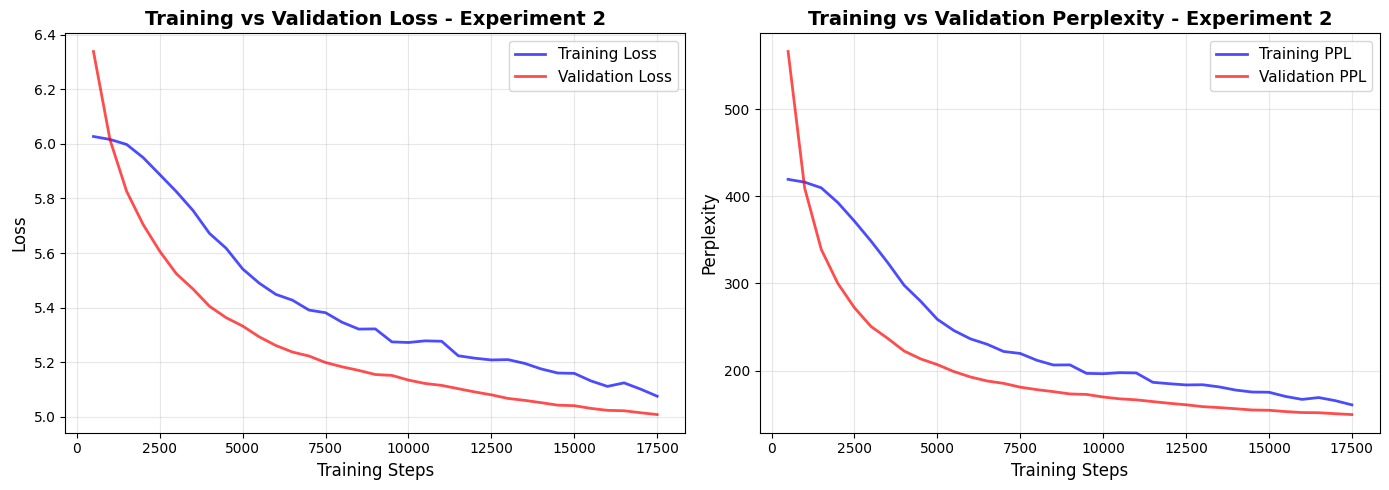


✓ Plot saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp2_training_curves.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("="*60)
print("EXPERIMENT 2: TRAINING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = exp2_step_history['step']
smooth_train_loss = uniform_filter1d(exp2_step_history['train_loss'], size=10)
smooth_train_ppl = uniform_filter1d(exp2_step_history['train_perplexity'], size=10)

axes[0].plot(steps, smooth_train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
axes[0].plot(steps, exp2_step_history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss - Experiment 2', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, smooth_train_ppl, 'b-', label='Training PPL', linewidth=2, alpha=0.7)
axes[1].plot(steps, exp2_step_history['val_perplexity'], 'r-', label='Validation PPL', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Training vs Validation Perplexity - Experiment 2', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/exp2_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

# Experiment 3: Embedding Dimension = 256

In [ ]:
print("="*60)
print("EXPERIMENT 3: EMBEDDING DIMENSION = 256")
print("="*60)
print("Config: embed_dim=256, heads=4, layers=2, lr=5e-4, batch_size=32")
print("="*60)

model_exp3 = MiniGPT(
    vocab_size=VOCAB_SIZE,
    embed_dim=256,
    num_heads=4,
    num_layers=2,
    max_seq_len=SEQ_LEN,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model_exp3.parameters()):,}")

optimizer_exp3 = torch.optim.AdamW(model_exp3.parameters(), lr=5e-4)

LOG_INTERVAL = 500

exp3_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

exp3_step_history = {
    'step': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("\nStarting training...\n")

global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    model_exp3.train()
    epoch_train_loss = 0
    num_train_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer_exp3.zero_grad()
        logits = model_exp3(input_ids)

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_exp3.parameters(), max_norm=1.0)
        optimizer_exp3.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        num_train_batches += 1
        global_step += 1

        current_avg_loss = epoch_train_loss / num_train_batches
        current_ppl = math.exp(current_avg_loss)
        progress_bar.set_postfix({
            'loss': f'{current_avg_loss:.4f}',
            'ppl': f'{current_ppl:.2f}'
        })

        if global_step % LOG_INTERVAL == 0:
            model_exp3.eval()
            val_loss_sample = 0
            with torch.no_grad():
                for i, val_batch in enumerate(val_loader):
                    if i >= 10:
                        break
                    val_input = val_batch['input_ids'].to(device)
                    val_labels = val_batch['labels'].to(device)
                    val_logits = model_exp3(val_input)
                    val_shift_logits = val_logits[:, :-1, :].contiguous()
                    val_shift_labels = val_labels[:, 1:].contiguous()
                    val_loss = F.cross_entropy(
                        val_shift_logits.view(-1, val_shift_logits.size(-1)),
                        val_shift_labels.view(-1)
                    )
                    val_loss_sample += val_loss.item()
            val_loss_sample /= 10

            exp3_step_history['step'].append(global_step)
            exp3_step_history['train_loss'].append(batch_loss)
            exp3_step_history['train_perplexity'].append(math.exp(batch_loss))
            exp3_step_history['val_loss'].append(val_loss_sample)
            exp3_step_history['val_perplexity'].append(math.exp(val_loss_sample))

            model_exp3.train()

    avg_train_loss = epoch_train_loss / num_train_batches
    train_perplexity = math.exp(avg_train_loss)

    print(f"\nRunning validation...")
    avg_val_loss = validate_epoch(model_exp3, val_loader, device)
    val_perplexity = math.exp(avg_val_loss)

    exp3_history['epoch'].append(epoch)
    exp3_history['train_loss'].append(avg_train_loss)
    exp3_history['train_perplexity'].append(train_perplexity)
    exp3_history['val_loss'].append(avg_val_loss)
    exp3_history['val_perplexity'].append(val_perplexity)

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training   -> Loss: {avg_train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"Validation -> Loss: {avg_val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    print(f"{'='*60}")

    checkpoint_path = f'{SAVE_DIR}/exp3_embed256_epoch{epoch}.pt'
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_exp3.state_dict(),
        'optimizer_state_dict': optimizer_exp3.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_perplexity': train_perplexity,
        'val_perplexity': val_perplexity,
        'epoch_history': exp3_history,
        'step_history': exp3_step_history
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("EXPERIMENT 3 COMPLETE!")
print("="*60)
print(f"Final Training Loss: {exp3_history['train_loss'][-1]:.4f}")
print(f"Final Training Perplexity: {exp3_history['train_perplexity'][-1]:.2f}")
print(f"Final Validation Loss: {exp3_history['val_loss'][-1]:.4f}")
print(f"Final Validation Perplexity: {exp3_history['val_perplexity'][-1]:.2f}")
print(f"Total steps logged: {len(exp3_step_history['step'])}")
print("="*60)

EXPERIMENT 3: EMBEDDING DIMENSION = 256
Config: embed_dim=256, heads=4, layers=2, lr=5e-4, batch_size=32
Model parameters: 27,344,384

Starting training...


EPOCH 1/2


Training Epoch 1: 100%|██████████| 8791/8791 [22:40<00:00,  6.46it/s, loss=5.4993, ppl=244.53]


Running validation...



EPOCH 1 SUMMARY
Training   -> Loss: 5.4993 | Perplexity: 244.53
Validation -> Loss: 5.0129 | Perplexity: 150.34
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp3_embed256_epoch1.pt

EPOCH 2/2


Training Epoch 2: 100%|██████████| 8791/8791 [22:41<00:00,  6.46it/s, loss=4.9689, ppl=143.86]


Running validation...



EPOCH 2 SUMMARY
Training   -> Loss: 4.9689 | Perplexity: 143.86
Validation -> Loss: 4.8102 | Perplexity: 122.75
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp3_embed256_epoch2.pt

EXPERIMENT 3 COMPLETE!
Final Training Loss: 4.9689
Final Training Perplexity: 143.86
Final Validation Loss: 4.8102
Final Validation Perplexity: 122.75
Total steps logged: 35


EXPERIMENT 3: TRAINING VISUALIZATION


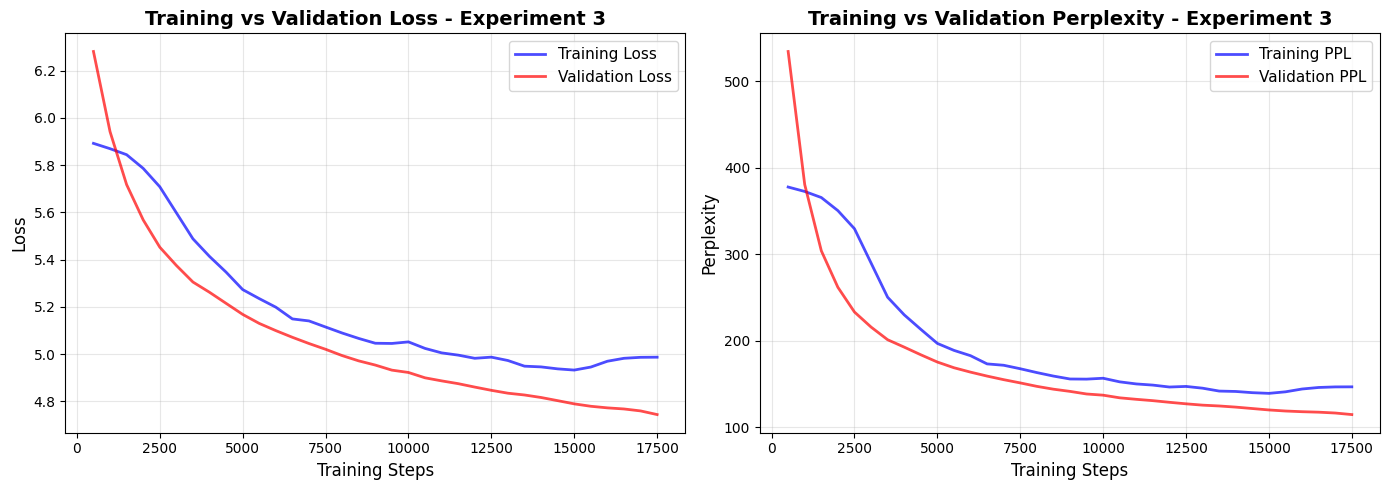


✓ Plot saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp3_training_curves.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("="*60)
print("EXPERIMENT 3: TRAINING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = exp3_step_history['step']
smooth_train_loss = uniform_filter1d(exp3_step_history['train_loss'], size=10)
smooth_train_ppl = uniform_filter1d(exp3_step_history['train_perplexity'], size=10)

axes[0].plot(steps, smooth_train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
axes[0].plot(steps, exp3_step_history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss - Experiment 3', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, smooth_train_ppl, 'b-', label='Training PPL', linewidth=2, alpha=0.7)
axes[1].plot(steps, exp3_step_history['val_perplexity'], 'r-', label='Validation PPL', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Training vs Validation Perplexity - Experiment 3', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/exp3_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

# Experiment 4: Number of Layers = 1

In [ ]:
print("="*60)
print("EXPERIMENT 4: NUMBER OF LAYERS = 1")
print("="*60)
print("Config: embed_dim=128, heads=4, layers=1, lr=5e-4, batch_size=32")
print("="*60)

model_exp4 = MiniGPT(
    vocab_size=VOCAB_SIZE,
    embed_dim=128,
    num_heads=4,
    num_layers=1,
    max_seq_len=SEQ_LEN,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model_exp4.parameters()):,}")

optimizer_exp4 = torch.optim.AdamW(model_exp4.parameters(), lr=5e-4)

LOG_INTERVAL = 500

exp4_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

exp4_step_history = {
    'step': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("\nStarting training...\n")

global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    model_exp4.train()
    epoch_train_loss = 0
    num_train_batches = 0

    progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer_exp4.zero_grad()
        logits = model_exp4(input_ids)

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_exp4.parameters(), max_norm=1.0)
        optimizer_exp4.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        num_train_batches += 1
        global_step += 1

        current_avg_loss = epoch_train_loss / num_train_batches
        current_ppl = math.exp(current_avg_loss)
        progress_bar.set_postfix({
            'loss': f'{current_avg_loss:.4f}',
            'ppl': f'{current_ppl:.2f}'
        })

        if global_step % LOG_INTERVAL == 0:
            model_exp4.eval()
            val_loss_sample = 0
            with torch.no_grad():
                for i, val_batch in enumerate(val_loader):
                    if i >= 10:
                        break
                    val_input = val_batch['input_ids'].to(device)
                    val_labels = val_batch['labels'].to(device)
                    val_logits = model_exp4(val_input)
                    val_shift_logits = val_logits[:, :-1, :].contiguous()
                    val_shift_labels = val_labels[:, 1:].contiguous()
                    val_loss = F.cross_entropy(
                        val_shift_logits.view(-1, val_shift_logits.size(-1)),
                        val_shift_labels.view(-1)
                    )
                    val_loss_sample += val_loss.item()
            val_loss_sample /= 10

            exp4_step_history['step'].append(global_step)
            exp4_step_history['train_loss'].append(batch_loss)
            exp4_step_history['train_perplexity'].append(math.exp(batch_loss))
            exp4_step_history['val_loss'].append(val_loss_sample)
            exp4_step_history['val_perplexity'].append(math.exp(val_loss_sample))

            model_exp4.train()

    avg_train_loss = epoch_train_loss / num_train_batches
    train_perplexity = math.exp(avg_train_loss)

    print(f"\nRunning validation...")
    avg_val_loss = validate_epoch(model_exp4, val_loader, device)
    val_perplexity = math.exp(avg_val_loss)

    exp4_history['epoch'].append(epoch)
    exp4_history['train_loss'].append(avg_train_loss)
    exp4_history['train_perplexity'].append(train_perplexity)
    exp4_history['val_loss'].append(avg_val_loss)
    exp4_history['val_perplexity'].append(val_perplexity)

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training   -> Loss: {avg_train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"Validation -> Loss: {avg_val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    print(f"{'='*60}")

    checkpoint_path = f'{SAVE_DIR}/exp4_layer1_epoch{epoch}.pt'
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_exp4.state_dict(),
        'optimizer_state_dict': optimizer_exp4.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_perplexity': train_perplexity,
        'val_perplexity': val_perplexity,
        'epoch_history': exp4_history,
        'step_history': exp4_step_history
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("EXPERIMENT 4 COMPLETE!")
print("="*60)
print(f"Final Training Loss: {exp4_history['train_loss'][-1]:.4f}")
print(f"Final Training Perplexity: {exp4_history['train_perplexity'][-1]:.2f}")
print(f"Final Validation Loss: {exp4_history['val_loss'][-1]:.4f}")
print(f"Final Validation Perplexity: {exp4_history['val_perplexity'][-1]:.2f}")
print(f"Total steps logged: {len(exp4_step_history['step'])}")
print("="*60)

EXPERIMENT 4: NUMBER OF LAYERS = 1
Config: embed_dim=128, heads=4, layers=1, lr=5e-4, batch_size=32
Model parameters: 13,080,704

Starting training...


EPOCH 1/2


Training Epoch 1: 100%|██████████| 8791/8791 [14:20<00:00, 10.22it/s, loss=5.7634, ppl=318.42]


Running validation...



EPOCH 1 SUMMARY
Training   -> Loss: 5.7634 | Perplexity: 318.42
Validation -> Loss: 5.2991 | Perplexity: 200.15
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp4_layer1_epoch1.pt

EPOCH 2/2


Training Epoch 2: 100%|██████████| 8791/8791 [14:24<00:00, 10.17it/s, loss=5.3000, ppl=200.34]


Running validation...



EPOCH 2 SUMMARY
Training   -> Loss: 5.3000 | Perplexity: 200.34
Validation -> Loss: 5.1661 | Perplexity: 175.23
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp4_layer1_epoch2.pt

EXPERIMENT 4 COMPLETE!
Final Training Loss: 5.3000
Final Training Perplexity: 200.34
Final Validation Loss: 5.1661
Final Validation Perplexity: 175.23
Total steps logged: 35


EXPERIMENT 4: TRAINING VISUALIZATION


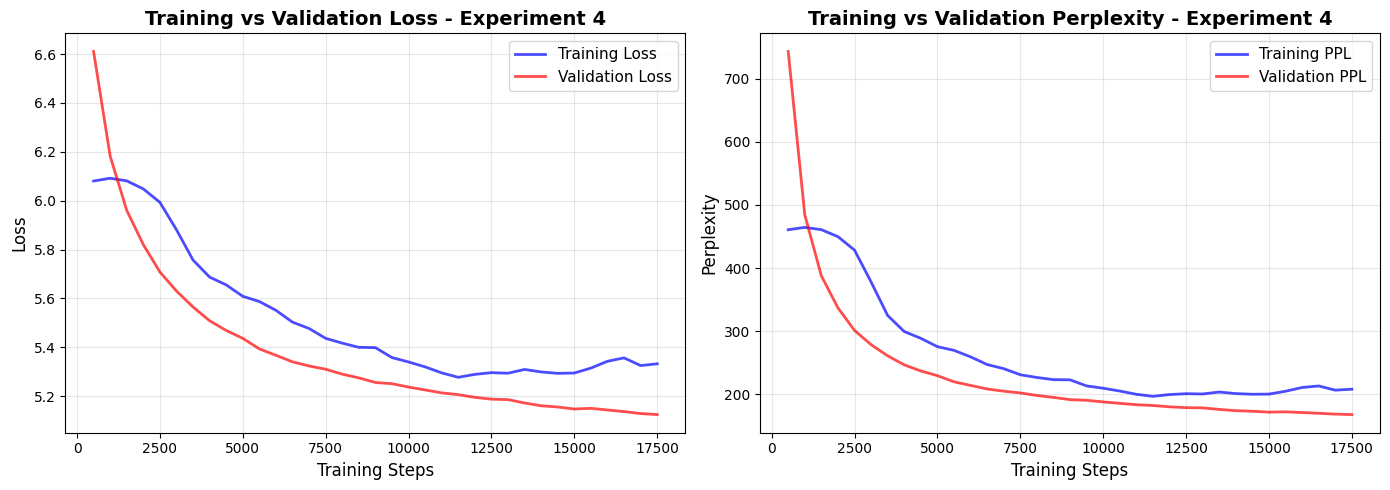


✓ Plot saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp4_training_curves.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("="*60)
print("EXPERIMENT 4: TRAINING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = exp4_step_history['step']
smooth_train_loss = uniform_filter1d(exp4_step_history['train_loss'], size=10)
smooth_train_ppl = uniform_filter1d(exp4_step_history['train_perplexity'], size=10)

axes[0].plot(steps, smooth_train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
axes[0].plot(steps, exp4_step_history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss - Experiment 4', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, smooth_train_ppl, 'b-', label='Training PPL', linewidth=2, alpha=0.7)
axes[1].plot(steps, exp4_step_history['val_perplexity'], 'r-', label='Validation PPL', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Training vs Validation Perplexity - Experiment 4', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/exp4_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

# Experiment 5: Batch Size = 64

In [ ]:
print("="*60)
print("CREATING DATALOADER FOR BATCH SIZE = 64")
print("="*60)

train_loader_bs64 = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader_bs64 = DataLoader(
    val_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Batch size: 64")
print(f"Train batches: {len(train_loader_bs64):,}")
print(f"Val batches: {len(val_loader_bs64):,}")
print(f"Steps per epoch: {len(train_loader_bs64):,}")
print("="*60)

CREATING DATALOADER FOR BATCH SIZE = 64
Batch size: 64
Train batches: 4,396
Val batches: 489
Steps per epoch: 4,396


In [ ]:
print("="*60)
print("EXPERIMENT 5: BATCH SIZE = 64")
print("="*60)
print("Config: embed_dim=128, heads=4, layers=2, lr=5e-4, batch_size=64")
print("="*60)

model_exp5 = MiniGPT(
    vocab_size=VOCAB_SIZE,
    embed_dim=128,
    num_heads=4,
    num_layers=2,
    max_seq_len=SEQ_LEN,
    dropout=0.1
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model_exp5.parameters()):,}")

optimizer_exp5 = torch.optim.AdamW(model_exp5.parameters(), lr=5e-4)

LOG_INTERVAL = 250

exp5_history = {
    'epoch': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

exp5_step_history = {
    'step': [],
    'train_loss': [],
    'train_perplexity': [],
    'val_loss': [],
    'val_perplexity': []
}

print("\nStarting training...\n")

global_step = 0

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*60}")
    print(f"EPOCH {epoch}/{NUM_EPOCHS}")
    print(f"{'='*60}")

    model_exp5.train()
    epoch_train_loss = 0
    num_train_batches = 0

    progress_bar = tqdm(train_loader_bs64, desc=f"Training Epoch {epoch}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer_exp5.zero_grad()
        logits = model_exp5(input_ids)

        shift_logits = logits[:, :-1, :].contiguous()
        shift_labels = labels[:, 1:].contiguous()

        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1)
        )

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_exp5.parameters(), max_norm=1.0)
        optimizer_exp5.step()

        batch_loss = loss.item()
        epoch_train_loss += batch_loss
        num_train_batches += 1
        global_step += 1

        current_avg_loss = epoch_train_loss / num_train_batches
        current_ppl = math.exp(current_avg_loss)
        progress_bar.set_postfix({
            'loss': f'{current_avg_loss:.4f}',
            'ppl': f'{current_ppl:.2f}'
        })

        if global_step % LOG_INTERVAL == 0:
            model_exp5.eval()
            val_loss_sample = 0
            with torch.no_grad():
                for i, val_batch in enumerate(val_loader_bs64):
                    if i >= 10:
                        break
                    val_input = val_batch['input_ids'].to(device)
                    val_labels = val_batch['labels'].to(device)
                    val_logits = model_exp5(val_input)
                    val_shift_logits = val_logits[:, :-1, :].contiguous()
                    val_shift_labels = val_labels[:, 1:].contiguous()
                    val_loss = F.cross_entropy(
                        val_shift_logits.view(-1, val_shift_logits.size(-1)),
                        val_shift_labels.view(-1)
                    )
                    val_loss_sample += val_loss.item()
            val_loss_sample /= 10

            exp5_step_history['step'].append(global_step)
            exp5_step_history['train_loss'].append(batch_loss)
            exp5_step_history['train_perplexity'].append(math.exp(batch_loss))
            exp5_step_history['val_loss'].append(val_loss_sample)
            exp5_step_history['val_perplexity'].append(math.exp(val_loss_sample))

            model_exp5.train()

    avg_train_loss = epoch_train_loss / num_train_batches
    train_perplexity = math.exp(avg_train_loss)

    print(f"\nRunning validation...")
    avg_val_loss = validate_epoch(model_exp5, val_loader_bs64, device)
    val_perplexity = math.exp(avg_val_loss)

    exp5_history['epoch'].append(epoch)
    exp5_history['train_loss'].append(avg_train_loss)
    exp5_history['train_perplexity'].append(train_perplexity)
    exp5_history['val_loss'].append(avg_val_loss)
    exp5_history['val_perplexity'].append(val_perplexity)

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch} SUMMARY")
    print(f"{'='*60}")
    print(f"Training   -> Loss: {avg_train_loss:.4f} | Perplexity: {train_perplexity:.2f}")
    print(f"Validation -> Loss: {avg_val_loss:.4f} | Perplexity: {val_perplexity:.2f}")
    print(f"{'='*60}")

    checkpoint_path = f'{SAVE_DIR}/exp5_bs64_epoch{epoch}.pt'
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model_exp5.state_dict(),
        'optimizer_state_dict': optimizer_exp5.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'train_perplexity': train_perplexity,
        'val_perplexity': val_perplexity,
        'epoch_history': exp5_history,
        'step_history': exp5_step_history
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint saved to: {checkpoint_path}")

print("\n" + "="*60)
print("EXPERIMENT 5 COMPLETE!")
print("="*60)
print(f"Final Training Loss: {exp5_history['train_loss'][-1]:.4f}")
print(f"Final Training Perplexity: {exp5_history['train_perplexity'][-1]:.2f}")
print(f"Final Validation Loss: {exp5_history['val_loss'][-1]:.4f}")
print(f"Final Validation Perplexity: {exp5_history['val_perplexity'][-1]:.2f}")
print(f"Total steps logged: {len(exp5_step_history['step'])}")
print("="*60)

EXPERIMENT 5: BATCH SIZE = 64
Config: embed_dim=128, heads=4, layers=2, lr=5e-4, batch_size=64
Model parameters: 13,278,976

Starting training...


EPOCH 1/2


Training Epoch 1: 100%|██████████| 4396/4396 [15:19<00:00,  4.78it/s, loss=5.8618, ppl=351.34]


Running validation...



EPOCH 1 SUMMARY
Training   -> Loss: 5.8618 | Perplexity: 351.34
Validation -> Loss: 5.3168 | Perplexity: 203.74
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp5_bs64_epoch1.pt

EPOCH 2/2


Training Epoch 2: 100%|██████████| 4396/4396 [15:24<00:00,  4.76it/s, loss=5.2881, ppl=197.96]


Running validation...



EPOCH 2 SUMMARY
Training   -> Loss: 5.2881 | Perplexity: 197.96
Validation -> Loss: 5.1137 | Perplexity: 166.28
✓ Checkpoint saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp5_bs64_epoch2.pt

EXPERIMENT 5 COMPLETE!
Final Training Loss: 5.2881
Final Training Perplexity: 197.96
Final Validation Loss: 5.1137
Final Validation Perplexity: 166.28
Total steps logged: 35


EXPERIMENT 5: TRAINING VISUALIZATION


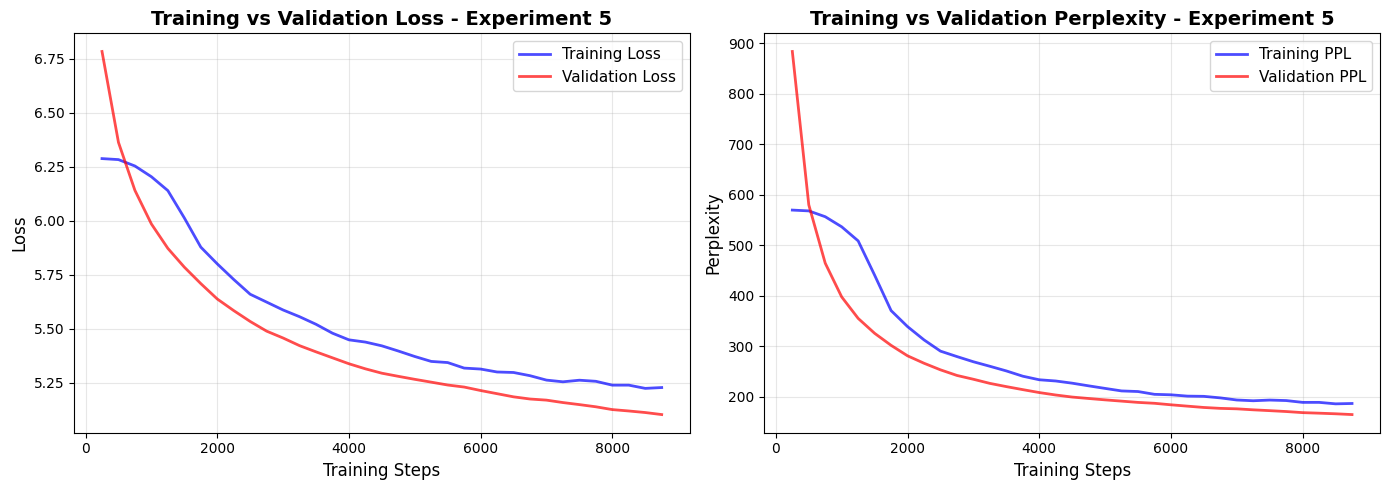


✓ Plot saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/exp5_training_curves.png


In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

print("="*60)
print("EXPERIMENT 5: TRAINING VISUALIZATION")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

steps = exp5_step_history['step']
smooth_train_loss = uniform_filter1d(exp5_step_history['train_loss'], size=10)
smooth_train_ppl = uniform_filter1d(exp5_step_history['train_perplexity'], size=10)

axes[0].plot(steps, smooth_train_loss, 'b-', label='Training Loss', linewidth=2, alpha=0.7)
axes[0].plot(steps, exp5_step_history['val_loss'], 'r-', label='Validation Loss', linewidth=2, alpha=0.7)
axes[0].set_xlabel('Training Steps', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss - Experiment 5', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

axes[1].plot(steps, smooth_train_ppl, 'b-', label='Training PPL', linewidth=2, alpha=0.7)
axes[1].plot(steps, exp5_step_history['val_perplexity'], 'r-', label='Validation PPL', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Training Steps', fontsize=12)
axes[1].set_ylabel('Perplexity', fontsize=12)
axes[1].set_title('Training vs Validation Perplexity - Experiment 5', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/exp5_training_curves.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to: {plot_path}")

# Final Experiment Comparison

FINAL EXPERIMENT COMPARISON


/tmp/ipython-input-1522896807.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


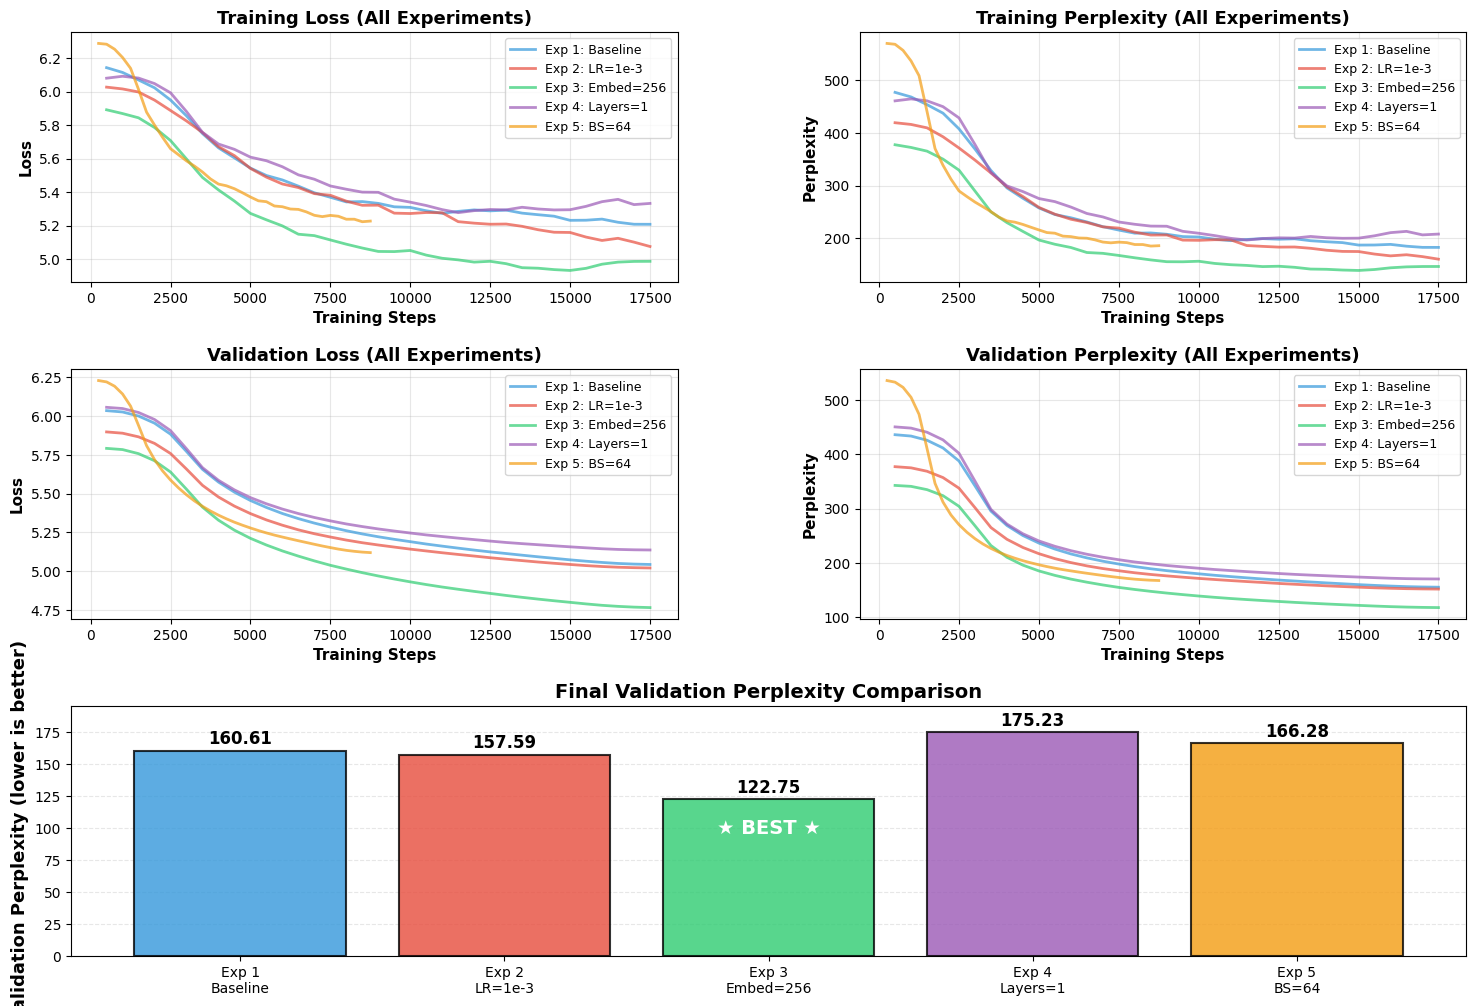


✓ Comprehensive comparison saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/final_comprehensive_comparison.png

Rank   Experiment      Configuration                                 Val PPL   
--------------------------------------------------------------------------------
🥇 1    Exp 3           embed=256, layers=2, lr=5e-4, bs=32           122.75    
🥈 2    Exp 2           embed=128, layers=2, lr=1e-3, bs=32           157.59    
🥉 3    Exp 1           embed=128, layers=2, lr=5e-4, bs=32           160.61    
   4    Exp 5           embed=128, layers=2, lr=5e-4, bs=64           166.28    
   5    Exp 4           embed=128, layers=1, lr=5e-4, bs=32           175.23    


In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import uniform_filter1d

SAVE_DIR = '/content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs'

# Load all checkpoints
exp1_ckpt = torch.load(f'{SAVE_DIR}/exp1_baseline_epoch2.pt', map_location='cpu')
exp2_ckpt = torch.load(f'{SAVE_DIR}/exp2_lr1e3_epoch2.pt', map_location='cpu')
exp3_ckpt = torch.load(f'{SAVE_DIR}/exp3_embed256_epoch2.pt', map_location='cpu')
exp4_ckpt = torch.load(f'{SAVE_DIR}/exp4_layer1_epoch2.pt', map_location='cpu')
exp5_ckpt = torch.load(f'{SAVE_DIR}/exp5_bs64_epoch2.pt', map_location='cpu')

step_history = exp1_ckpt['step_history']
exp1_history = exp1_ckpt['epoch_history']
exp2_step_history = exp2_ckpt['step_history']
exp2_history = exp2_ckpt['epoch_history']
exp3_step_history = exp3_ckpt['step_history']
exp3_history = exp3_ckpt['epoch_history']
exp4_step_history = exp4_ckpt['step_history']
exp4_history = exp4_ckpt['epoch_history']
exp5_step_history = exp5_ckpt['step_history']
exp5_history = exp5_ckpt['epoch_history']

print("="*60)
print("FINAL EXPERIMENT COMPARISON")
print("="*60)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, height_ratios=[1, 1, 1], hspace=0.35, wspace=0.3)

ax_train_loss = fig.add_subplot(gs[0, 0])
ax_train_ppl = fig.add_subplot(gs[0, 1])
ax_val_loss = fig.add_subplot(gs[1, 0])
ax_val_ppl = fig.add_subplot(gs[1, 1])
ax_bar = fig.add_subplot(gs[2, :])

experiments_data = [
    ('Exp 1: Baseline', step_history, exp1_history, '#3498db'),
    ('Exp 2: LR=1e-3', exp2_step_history, exp2_history, '#e74c3c'),
    ('Exp 3: Embed=256', exp3_step_history, exp3_history, '#2ecc71'),
    ('Exp 4: Layers=1', exp4_step_history, exp4_history, '#9b59b6'),
    ('Exp 5: BS=64', exp5_step_history, exp5_history, '#f39c12')
]

for name, step_hist, epoch_hist, color in experiments_data:
    steps = step_hist['step']
    smooth_train_loss = uniform_filter1d(step_hist['train_loss'], size=10)
    smooth_train_ppl = uniform_filter1d(step_hist['train_perplexity'], size=10)
    smooth_val_loss = uniform_filter1d(step_hist['val_loss'], size=10)
    smooth_val_ppl = uniform_filter1d(step_hist['val_perplexity'], size=10)

    ax_train_loss.plot(steps, smooth_train_loss, '-', color=color, linewidth=2, alpha=0.7, label=name)
    ax_train_ppl.plot(steps, smooth_train_ppl, '-', color=color, linewidth=2, alpha=0.7, label=name)
    ax_val_loss.plot(steps, smooth_val_loss, '-', color=color, linewidth=2, alpha=0.7, label=name)
    ax_val_ppl.plot(steps, smooth_val_ppl, '-', color=color, linewidth=2, alpha=0.7, label=name)

ax_train_loss.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax_train_loss.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax_train_loss.set_title('Training Loss (All Experiments)', fontsize=13, fontweight='bold')
ax_train_loss.legend(fontsize=9, loc='upper right')
ax_train_loss.grid(True, alpha=0.3)

ax_train_ppl.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax_train_ppl.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
ax_train_ppl.set_title('Training Perplexity (All Experiments)', fontsize=13, fontweight='bold')
ax_train_ppl.legend(fontsize=9, loc='upper right')
ax_train_ppl.grid(True, alpha=0.3)

ax_val_loss.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax_val_loss.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax_val_loss.set_title('Validation Loss (All Experiments)', fontsize=13, fontweight='bold')
ax_val_loss.legend(fontsize=9, loc='upper right')
ax_val_loss.grid(True, alpha=0.3)

ax_val_ppl.set_xlabel('Training Steps', fontsize=11, fontweight='bold')
ax_val_ppl.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
ax_val_ppl.set_title('Validation Perplexity (All Experiments)', fontsize=13, fontweight='bold')
ax_val_ppl.legend(fontsize=9, loc='upper right')
ax_val_ppl.grid(True, alpha=0.3)

# Bar chart from checkpoint data
exp_names = ['Exp 1\nBaseline', 'Exp 2\nLR=1e-3', 'Exp 3\nEmbed=256', 'Exp 4\nLayers=1', 'Exp 5\nBS=64']
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']
final_val_ppls = [eh['val_perplexity'][-1] for _, _, eh, _ in experiments_data]

bars = ax_bar.bar(exp_names, final_val_ppls,
                   color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)

best_idx = np.argmin(final_val_ppls)
for i, bar in enumerate(bars):
    height = bar.get_height()
    label = f'{height:.2f}'
    if i == best_idx:
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 2,
                    label, ha='center', va='bottom', fontsize=12, fontweight='bold')
        ax_bar.text(bar.get_x() + bar.get_width()/2., height - 15,
                    '★ BEST ★', ha='center', va='top', fontsize=14, fontweight='bold', color='white')
    else:
        ax_bar.text(bar.get_x() + bar.get_width()/2., height + 2,
                    label, ha='center', va='bottom', fontsize=12, fontweight='bold')

ax_bar.set_ylabel('Validation Perplexity (lower is better)', fontsize=13, fontweight='bold')
ax_bar.set_title('Final Validation Perplexity Comparison', fontsize=14, fontweight='bold')
ax_bar.set_ylim(0, max(final_val_ppls) + 20)
ax_bar.grid(axis='y', alpha=0.3, linestyle='--')
ax_bar.set_axisbelow(True)

plt.tight_layout()
plot_path = f'{SAVE_DIR}/final_comprehensive_comparison.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Comprehensive comparison saved to: {plot_path}")

# Summary table
configs = [
    ('Exp 1', 'embed=128, layers=2, lr=5e-4, bs=32'),
    ('Exp 2', 'embed=128, layers=2, lr=1e-3, bs=32'),
    ('Exp 3', 'embed=256, layers=2, lr=5e-4, bs=32'),
    ('Exp 4', 'embed=128, layers=1, lr=5e-4, bs=32'),
    ('Exp 5', 'embed=128, layers=2, lr=5e-4, bs=64')
]

print("\n" + "="*80)
print(f"{'Rank':<6} {'Experiment':<15} {'Configuration':<45} {'Val PPL':<10}")
print("-" * 80)

sorted_exps = sorted(
    [(name, config, ppl) for (name, config), ppl in zip(configs, final_val_ppls)],
    key=lambda x: x[2]
)

for i, (exp_name, config, ppl) in enumerate(sorted_exps, 1):
    medal = '🥇' if i == 1 else '🥈' if i == 2 else '🥉' if i == 3 else '  '
    print(f"{medal} {i:<4} {exp_name:<15} {config:<45} {ppl:<10.2f}")

print("="*80)

# Save Best Model Checkpoint

In [ ]:
print("="*60)
print("SAVING BEST MODEL (EXPERIMENT 3)")
print("="*60)

final_model_path = f'{SAVE_DIR}/mini_gpt_checkpoint.pt'

torch.save({
    'model_state_dict': model_exp3.state_dict(),
    'config': {
        'vocab_size': VOCAB_SIZE,
        'embed_dim': 256,
        'num_heads': 4,
        'num_layers': 2,
        'max_seq_len': SEQ_LEN,
        'dropout': 0.1
    },
    'training_info': {
        'final_train_loss': exp3_history['train_loss'][-1],
        'final_val_loss': exp3_history['val_loss'][-1],
        'final_train_perplexity': exp3_history['train_perplexity'][-1],
        'final_val_perplexity': exp3_history['val_perplexity'][-1],
        'num_epochs': NUM_EPOCHS,
        'learning_rate': 5e-4,
        'batch_size': BATCH_SIZE
    }
}, final_model_path)

print(f"✓ Best model saved to: {final_model_path}")
print(f"\nModel Details:")
print(f"  Architecture: MiniGPT")
print(f"  Embedding Dimension: 256")
print(f"  Attention Heads: 4")
print(f"  Transformer Layers: 2")
print(f"  Parameters: {sum(p.numel() for p in model_exp3.parameters()):,}")
print(f"  Final Validation Perplexity: {exp3_history['val_perplexity'][-1]:.2f}")
print("="*60)

SAVING BEST MODEL (EXPERIMENT 3)
✓ Best model saved to: /content/drive/MyDrive/NEU/CSYE7374/assignment2/outputs/mini_gpt_checkpoint.pt

Model Details:
  Architecture: MiniGPT
  Embedding Dimension: 256
  Attention Heads: 4
  Transformer Layers: 2
  Parameters: 27,344,384
  Final Validation Perplexity: 122.75


# Text Generation - Best Model

In [ ]:
from transformers import GPT2Tokenizer

print("="*60)
print("TEXT GENERATION FROM BEST MODEL")
print("="*60)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def generate_text(model, prompt, max_new_tokens=50, temperature=0.8, top_k=40):
    model.eval()
    tokens = tokenizer.encode(prompt)
    input_ids = torch.tensor([tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_new_tokens):
            if input_ids.size(1) >= SEQ_LEN:
                input_ids = input_ids[:, -SEQ_LEN:]

            logits = model(input_ids)
            logits = logits[:, -1, :] / temperature

            if top_k > 0:
                indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
                logits[indices_to_remove] = float('-inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            input_ids = torch.cat([input_ids, next_token], dim=1)

    return tokenizer.decode(input_ids[0].tolist())

prompts = [
    "The meaning of life is",
    "In the year 2050,",
    "Scientists have discovered that",
    "The president announced",
    "Once upon a time"
]

print("\nGenerating text samples...\n")

for i, prompt in enumerate(prompts, 1):
    print(f"{i}. Prompt: \"{prompt}\"")
    generated = generate_text(model_exp3, prompt, max_new_tokens=40, temperature=0.8, top_k=40)
    print(f"   Generated: {generated}")
    print("-" * 80)

print("\n✓ Text generation complete!")
print("="*60)

TEXT GENERATION FROM BEST MODEL


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]


Generating text samples...

1. Prompt: "The meaning of life is"
   Generated: The meaning of life is something that is supposed to be done in life. the time i realized that i could have found the experience of the age of life has been working at the same time i learned before i felt that i
--------------------------------------------------------------------------------
2. Prompt: "In the year 2050,"
   Generated: In the year 2050, by 2050, the growth of this economy may result, the global economy's economy will be higher, and the result of a "fiscal" rate of unemployment in the world's economy. in the
--------------------------------------------------------------------------------
3. Prompt: "Scientists have discovered that"
   Generated: Scientists have discovered that theres a new problem. theyre not a thing to do. there are many new types of tools, so i think theyve done it. its important to understand the premise of the process we
--------------------------------------------------

#  Upload Model to Hugging Face

In [14]:
print("="*60)
print("UPLOAD MODEL TO HUGGING FACE")
print("="*60)

!pip install -q huggingface_hub

from huggingface_hub import HfApi, login

login()

api = HfApi()
repo_id = "Avvvvva/mini-gpt-foundation-model"

api.create_repo(repo_id, exist_ok=True)

api.upload_file(
    path_or_fileobj=f'{SAVE_DIR}/mini_gpt_checkpoint.pt',
    path_in_repo="mini_gpt_checkpoint.pt",
    repo_id=repo_id
)

print(f"\n✓ Model uploaded to: https://huggingface.co/{repo_id}")

UPLOAD MODEL TO HUGGING FACE


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ts/mini_gpt_checkpoint.pt:   1%|          |  552kB /  109MB            


✓ Model uploaded to: https://huggingface.co/Avvvvva/mini-gpt-foundation-model
